C:\Bin\Python\Python312\Lib\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Bin\Python\Python312\Lib\site-packages\sklearn\cluster\_agglomerative.py:567: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Data saved to clustered_chemical_data_20250210_205627.csv


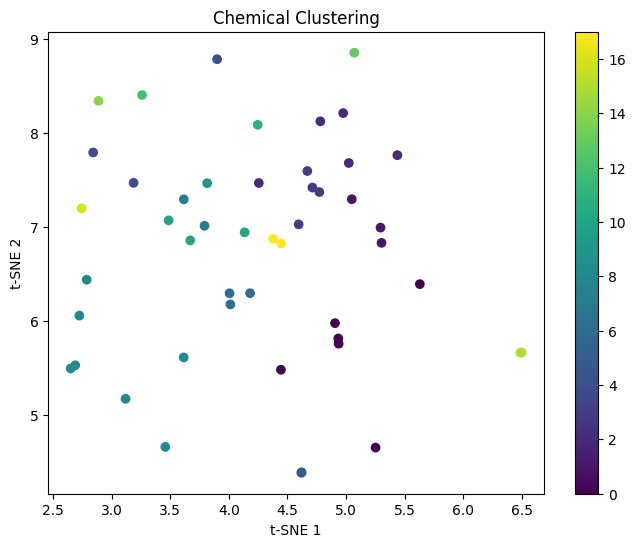

In [5]:
# Chemical Clustering Based on Similarity with Extended Fingerprint Options and Sorted Clusters

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, RDKFingerprint
from rdkit.Avalon import pyAvalonTools
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter

# Function to compute fingerprints
def compute_fingerprints(molecules, fingerprint_type):
    if fingerprint_type == 'morgan' or fingerprint_type == 'ecfp':
        return [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in molecules]
    elif fingerprint_type == 'maccs':
        return [MACCSkeys.GenMACCSKeys(mol) for mol in molecules]
    elif fingerprint_type == 'rdkit':
        return [RDKFingerprint(mol) for mol in molecules]
    elif fingerprint_type == 'atom_pair':
        return [AllChem.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in molecules]
    elif fingerprint_type == 'daylight':
        return [pyAvalonTools.GetAvalonFP(mol) for mol in molecules]
    elif fingerprint_type == 'chemical_hashed':
        return [AllChem.RDKFingerprint(mol, fpSize=1024) for mol in molecules]
    elif fingerprint_type == 'fcfp':
        return [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useFeatures=True) for mol in molecules]
    elif fingerprint_type == 'topological':
        return [Chem.RDKFingerprint(mol) for mol in molecules]
    elif fingerprint_type == 'pharmacophore':
        return [AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in molecules]
    elif fingerprint_type == 'substructure':
        return [AllChem.GetMACCSKeysFingerprint(mol) for mol in molecules]
    else:
        raise ValueError(f"Unknown fingerprint type: {fingerprint_type}")

# Step 1: Load the CSV file
df_smiles = pd.read_csv('path_to_your_file.csv')  # Update the path to your file

# Ensure that the column name matches the one in your CSV
smiles_data = df_smiles['SMILES'].tolist()

# Step 2: Convert SMILES to RDKit molecules
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_data]

# Step 3: Choose fingerprint type and compute fingerprints
fingerprint_type = 'morgan'  # Change to 'maccs', 'rdkit', 'atom_pair', 'daylight', 'ecfp', 'chemical_hashed', 'fcfp', 'topological', 'pharmacophore', or 'substructure' as needed
fingerprints = compute_fingerprints(molecules, fingerprint_type)

# Convert fingerprints to numpy array
fingerprint_array = np.array([np.array(fp) for fp in fingerprints])

# Step 4: Compute pairwise distances (1 - Tanimoto similarity)
distance_matrix = pairwise_distances(fingerprint_array, metric='jaccard')

# Step 5: Perform hierarchical clustering with a distance threshold
distance_threshold = 0.2  # Set your desired distance threshold
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage='average')
cluster_labels = clustering.fit_predict(distance_matrix)

# Add cluster labels to the original DataFrame
df_smiles['Cluster'] = cluster_labels

# Step 6: Sort DataFrame based on cluster size
cluster_counts = Counter(cluster_labels)
sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)
sorted_cluster_labels = [cluster for cluster, count in sorted_clusters]

df_smiles['Cluster'] = pd.Categorical(df_smiles['Cluster'], categories=sorted_cluster_labels, ordered=True)
df_smiles = df_smiles.sort_values('Cluster')

# Step 7: Automatically rename and save the DataFrame to a CSV file
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_filename = f'clustered_chemical_data_{timestamp}.csv'
df_smiles.to_csv(output_filename, index=False)
print(f'Data saved to {output_filename}')

# Step 8: Optional - Visualize the clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(fingerprint_array)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Chemical Clustering')
plt.colorbar()
plt.show()
